# Training and evaluation in `eo-flow`

Set up paths to data and check few EOPatches, and get some stats on label distribution

In [1]:
import os

from eolearn.core import EOPatch, FeatureType
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Path to your `EOPatch` folders, split into `train` and `test` sub-folders

In [2]:
root_dir = 'path-to-eopatches'

Let's check an EOPatch

In [ ]:
eop = EOPatch.load(os.path.join(root_dir, 'train', 'eopatch-17x11'))

In [4]:
eop

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(23, 1010, 999, 9), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC_RABA: numpy.ndarray(shape=(1010, 999, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((540141.9938823571, 5135790.459732607), (550136.7861024287, 5145887.882684642)), crs=EPSG:32633)
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 12, 19, 0, 0)], length=23
)

Patches are too big for training. We will have to split them into smaller subpatches.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


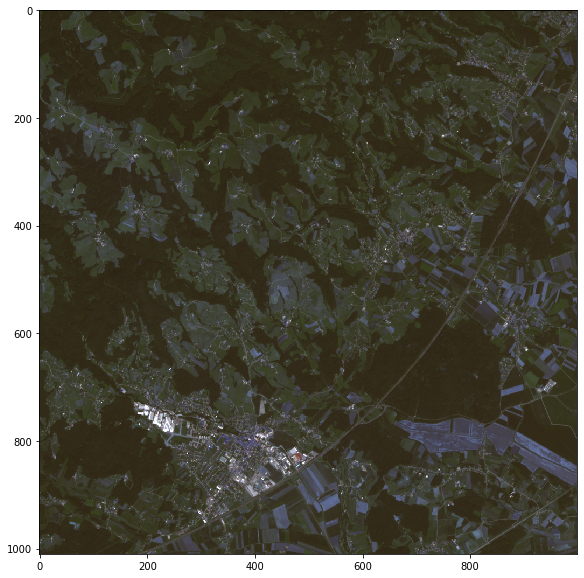

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(eop.data['FEATURES'][12][...,[0,1,2]] * 2.5)

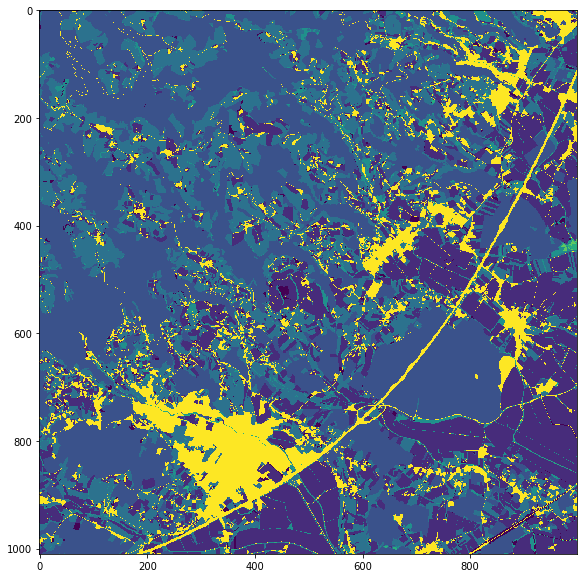

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(eop.mask_timeless['LULC_RABA'].squeeze(), vmin=0, vmax=8)

In [7]:
# Check for NaN values in each timeslice
np.mean(np.isnan(eop.data['FEATURES']), axis=(1,2,3))

array([0.00723397, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [8]:
eop.mask_timeless['LULC_RABA'].max()

8

In [9]:
train_data_path = os.path.join(root_dir, 'train')
val_data_path = os.path.join(root_dir, 'test')

## Import `eo-flow` modules

In [10]:
import tensorflow as tf
import json

from eoflow.models import TFCNModel
from eoflow.input.eopatch import eopatch_dataset
from eoflow.input.operations import augment_data, cache_dataset, extract_subpatches
from eoflow.utils import create_dirs

## Prepare the input data

Create the input pipeline

In [11]:
n_classes = 10
model_directory = "./tfcn_experiment/"

In [ ]:
def build_dataset(dataset_dir, is_train, batch_size=1):
    """ Creates a tensorflow dataset from EOPatches in a given directory. """
    
    # Read features and labels into a tf dataset object using the `eopatch_dataset` method
    features_data = [
        # (feature_type, feature_name, out_feature_name, dtype, feature_shape)
        (FeatureType.DATA, 'FEATURES', 'features', np.float32, [23, None, None, 9]),
        (FeatureType.MASK_TIMELESS, 'LULC_RABA', 'labels', np.int64, [None, None, 1])
    ]
    dataset = eopatch_dataset(dataset_dir, features_data, fill_na=-2)
    
    # Extract random subpatches
    patch_size = (128, 128)
    features_to_extract = [
        # (feature_name, height_and_width_axis)
        ('features', [1,2]),
        ('labels', [0,1])
    ]
    extract_fn = extract_subpatches(
        patch_size,
        features_to_extract,
        random_sampling=True,
        num_random_samples=10
    )
    # Interleave patches extracted from multiple EOPatches
    dataset = dataset.interleave(extract_fn, 5)
    
    # Dataset caching. The sampling is performed only in the first iteration, and the samples cached
    cache_file = os.path.join(model_directory, "data_train" if is_train else "data_val")
    dataset = dataset.cache()
    
    # Shuffle and data augmentation (if training)
    # For augmentation use flipping (vertical and horizontal) and brightness for the input image
    if is_train:
        # Shuffle samples
        dataset = dataset.shuffle(buffer_size=50)
        
        # Randomly augment the data
        feature_augmentation_cfg = [
            # (feature_name, augmentations_list)
            # Possible augmentations: flip_left_right, flip_up_down, rotate, brightness, contrast
            ('features', ['flip_left_right', 'flip_up_down', 'brightness']),
            ('labels', ['flip_left_right', 'flip_up_down'])
        ]
        dataset = dataset.map(augment_data(feature_augmentation_cfg))
    
    # Prepare the data and return features and labels seperately
    def _prepare_data(data):
        features = data['features']
        labels = data['labels'][...,0]

        # One-hot encode the labels
        labels_oh = tf.one_hot(labels, depth=n_classes)

        return features, labels_oh

    dataset = dataset.map(_prepare_data)

    # Create batches
    dataset = dataset.batch(batch_size)
    
    return dataset
    
# Training dataset
train_input = build_dataset(train_data_path, True, batch_size=5)

# Validation dataset_fn
val_input = build_dataset(val_data_path, False, batch_size=5)

Initialize the model with configuration

In [14]:
# Model configuration
model_cfg = {
    "learning_rate": 0.0001,
    "n_layers": 3,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "features_root": 16,
    "conv_size": 3,
    "conv_stride": 1,
    "deconv_size": 2,
    "add_dropout": True,
    "add_batch_norm": False,
    "bias_init": 0.0,
    "padding": "VALID",
    "pool_size": 2,
    "pool_stride": 2,
    "pool_time": False,
    "single_encoding_conv": True,
    "conv_size_reduce": 3,
    "loss": "focal_loss",
    "metrics": ["accuracy", "iou"],
    "prediction_visualization": True
}
    
# Initialize model with configuration
model = TFCNModel(model_cfg)

In [17]:
# Prepare the model (must be run before training)
model.prepare()

Train the model. We can interrupt the training early using the interrupt command (stop button).

In [18]:
# Train the model
model.train_and_evaluate(
    train_dataset=train_input,
    val_dataset=val_input,
    num_epochs=10,
    iterations_per_epoch=100,
    model_directory=model_directory,
    save_steps=50, 
    summary_steps='epoch'
)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 1141s 11s/step - loss: 1.9883 - accuracy: 0.3747 - mean_iou: 0.0742 - val_loss: 1.4648 - val_accuracy: 0.7144 - val_mean_iou: 0.1793
Epoch 2/10
100/4 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1063s 11s/step - loss

### Predict with model

Use the `predict` function to run the prediction on a dataset.

In [19]:
predictions = model.predict(val_input)

In [21]:
predictions.shape

(20, 60, 60, 10)

In [23]:
predicted_classes = np.argmax(predictions, axis=3)
predicted_classes.shape

(20, 60, 60)

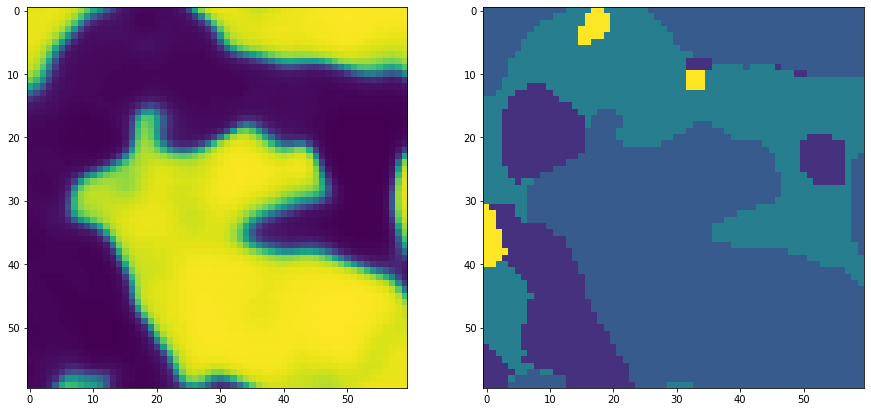

In [24]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(predictions[0][...,2])
ax2.imshow(predicted_classes[0], vmin=0, vmax=7)

## Evaluate the model

For the evaluation use the `evaluate` function. The metrics used for evaluation are defined in the model.

In [26]:
metrics = model.evaluate(val_input)

4/4 [==============================] - 3s 638ms/step - loss: 0.6293 - accuracy: 0.7955 - mean_iou: 0.3188


In [28]:
{metric_name:metric for metric, metric_name in zip(metrics, model.metrics_names)}

{'loss': 0.6293014883995056, 'accuracy': 0.7954583, 'mean_iou': 0.31882656}

## Other methods

EOFlow model inherits from `tf.keras.Model`. All the methods from the Keras models can be called on the model. Above we used the `predict` and `evaluate` methods. Behind the scenes the `train_and_evaluate` methods calls the keras `fit` method. Custom callbacks can be provided to this method.

## Other data loaders

This notebook showed how data can be read directly from eopatches. In the `examples` directory, code to create datasets from numpy arrays can be found. Numpy arrays can be used directly for training and testing as per the `Keras` API.